In [1]:
import requests
from zipfile import ZipFile
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('dark')
%matplotlib inline

# Explain dataset and where it comes from and why it is important.

In [2]:
df = pd.DataFrame(columns=['Duration', 'Start date', 'End date', 'Start station number',
                            'Start station', 'End station number', 'End station', 'Bike number',
                            'Member type'])
for year in range(2010, 2012): 
    # the data goes up to 2017, but the files are extremely large from 2011 onwards - 
    # you can decide to just use a subset
    url = f"https://s3.amazonaws.com/capitalbikeshare-data/{str(year)}-capitalbikeshare-tripdata.zip"
    r = requests.get(url, allow_redirects = True)
    zipfile_name = 'bikedata.zip'
    open(zipfile_name, 'wb').write(r.content)
    with ZipFile(zipfile_name, 'r') as zip:
        zip.extractall()
    zf = ZipFile(zipfile_name) 
    csv_name = f"{year}-capitalbikeshare-tripdata.csv"
    intermediate_df = pd.read_csv(open(csv_name), parse_dates=['Start date', 'End date'])
    df = pd.concat([df, intermediate_df])

In [3]:
df.head()

,Duration,Start date,End date,Start station number,Start station,End station number,End station,Bike number,Member type
0,1012,2010-09-20 11:27:04,2010-09-20 11:43:56,31208,M St & New Jersey Ave SE,31108,4th & M St SW,W00742,Member
1,61,2010-09-20 11:41:22,2010-09-20 11:42:23,31209,1st & N St SE,31209,1st & N St SE,W00032,Member
2,2690,2010-09-20 12:05:37,2010-09-20 12:50:27,31600,5th & K St NW,31100,19th St & Pennsylvania Ave NW,W00993,Member
3,1406,2010-09-20 12:06:05,2010-09-20 12:29:32,31600,5th & K St NW,31602,Park Rd & Holmead Pl NW,W00344,Member
4,1413,2010-09-20 12:10:43,2010-09-20 12:34:17,31100,19th St & Pennsylvania Ave NW,31201,15th & P St NW,W00883,Member


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1342364 entries, 0 to 1226766
Data columns (total 9 columns):
 #   Column                Non-Null Count    Dtype         
---  ------                --------------    -----         
 0   Duration              1342364 non-null  object        
 1   Start date            1342364 non-null  datetime64[ns]
 2   End date              1342364 non-null  datetime64[ns]
 3   Start station number  1342364 non-null  object        
 4   Start station         1342364 non-null  object        
 5   End station number    1342364 non-null  object        
 6   End station           1342364 non-null  object        
 7   Bike number           1342364 non-null  object        
 8   Member type           1342364 non-null  object        
dtypes: datetime64[ns](2), object(7)
memory usage: 102.4+ MB


In [5]:
# replace empty spaces and lower case everything.
df.columns = df.columns.str.replace(' ','_').str.lower()

# Create extra date variables that will be useful for modelling.
df['day_of_week'] = df.start_date.dt.day_name()
df['days_since_jan1_2010'] =(df.start_date - pd.Timestamp('2010-01-01')).dt.days
df['date'] = df.start_date.dt.floor(freq='D')  
df['is_weekend'] = np.where(df.start_date.dt.day_of_week >= 6, 'weekend', 'weekday')
df['hour'] = df.start_date.dt.hour
# Creating a unique route variable will help with groupby operations. 
df['route'] = df['start_station'] + df['end_station']

# 1 if they are a Member and 0 otherwise.
df['member_type'] = np.where(df['member_type'] == 'Member', 1, 0)

### Get Weather Data

For the weather data I used [visual crossing](https://www.visualcrossing.com/weather/weather-data-services), a publicly funded weather tracking site that stores historical weather data. Thankfully they have the data for Washington from 2010-2011.

In [6]:
weather_df = pd.read_csv('Washington_Weather.csv', 
                    parse_dates=['datetime'],
                    usecols=['datetime','temp', 'conditions'],
                    )
weather_df.rename({'datetime': 'date'}, axis=1, inplace=True)
df = df.merge(weather_df, on='date')
weather_df.head()

,date,temp,conditions
0,2010-09-20,22.5,Partially cloudy
1,2010-09-21,20.1,Clear
2,2010-09-22,25.8,Partially cloudy
3,2010-09-23,26.9,Partially cloudy
4,2010-09-24,28.3,Partially cloudy


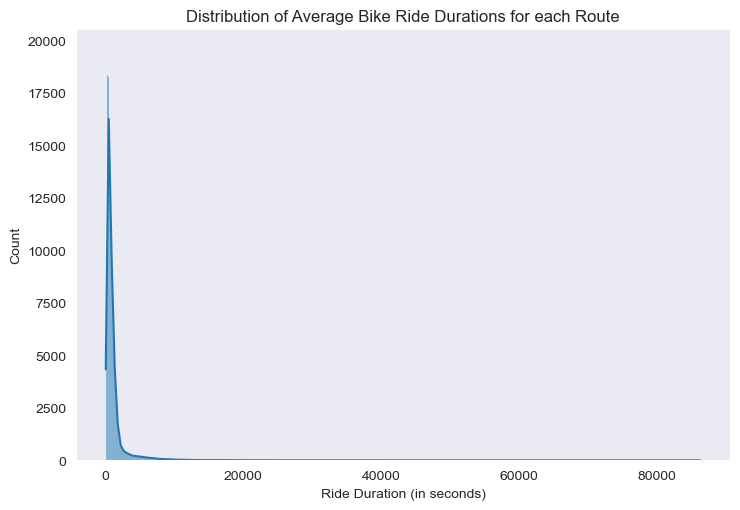

In [7]:
f = sns.displot(df['duration'], aspect=1.5, kde=True)
f.set(title='Distribution of Average Bike Ride Durations for each Route', xlabel='Ride Duration (in seconds)');

In [8]:
print(f"Number of rides longer than 40000 seconds: {np.sum(df['duration'] > 40000)}")

Number of rides longer than 40000 seconds: 1089


Given the size of our dataset it isn't surprising that there are significant outliers. For example. there are 1089 rides that were longer than 11 hours. The long tail in the figure above means we have reason to remove outliers which are likely due to faulty data or lost bikes that were returned hours later. To address these outliers, I remove all rides that are further than 3 standard deviations, thereby removing around 1% of the total samples.

In [9]:
standard_dev = df['duration'].std() * 3
df = df[df['duration'] < standard_dev]

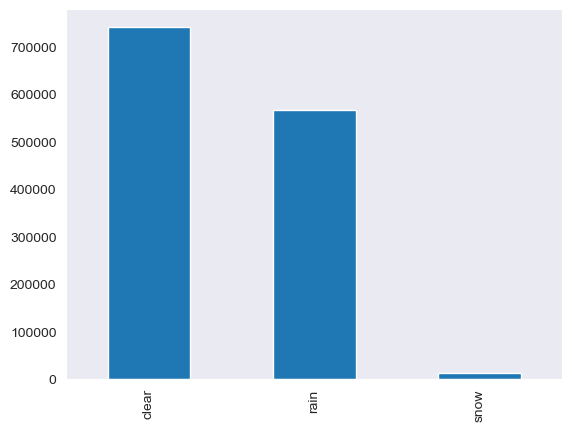

In [10]:
def format_weather(row):
    if 'Rain' in row:
        return 'rain'
    elif 'Snow' in row:
        return 'snow'
    return 'clear'

df['conditions'] = df['conditions'].apply(format_weather)
df['conditions'].value_counts().plot.bar();

In [11]:
df.day_of_week.value_counts()

Friday       194946
Tuesday      192066
Monday       190946
Saturday     189725
Thursday     185789
Sunday       184048
Wednesday    182391
Name: day_of_week, dtype: int64

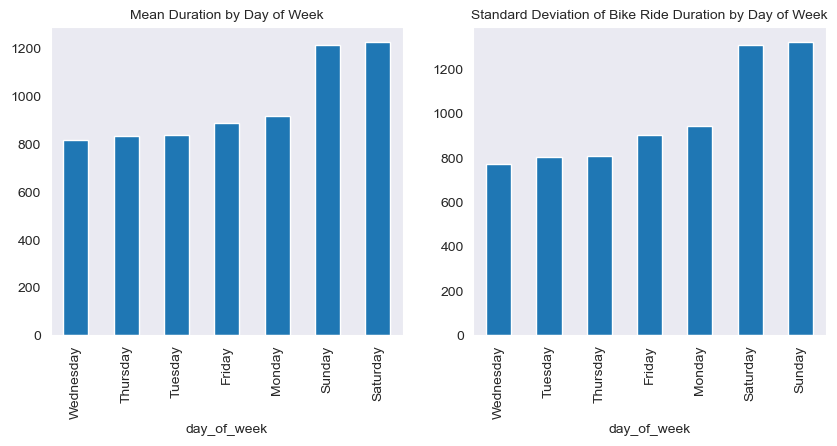

In [12]:
fig, ax = plt.subplots(1,2, figsize=(10,4))
df.groupby('day_of_week')['duration'].mean().sort_values().plot.bar(ax=ax[0])
df.groupby('day_of_week')['duration'].std().sort_values().plot.bar(ax=ax[1])
ax[0].set_title('Mean Duration by Day of Week', fontsize=10)
ax[1].set_title('Standard Deviation of Bike Ride Duration by Day of Week', fontsize=10);

The weekend has the longest rides with the most variation. However, the other days of the week don't seem to follow a definitive hierarchy with the exception of monday having the longest ride times and with the most variation.

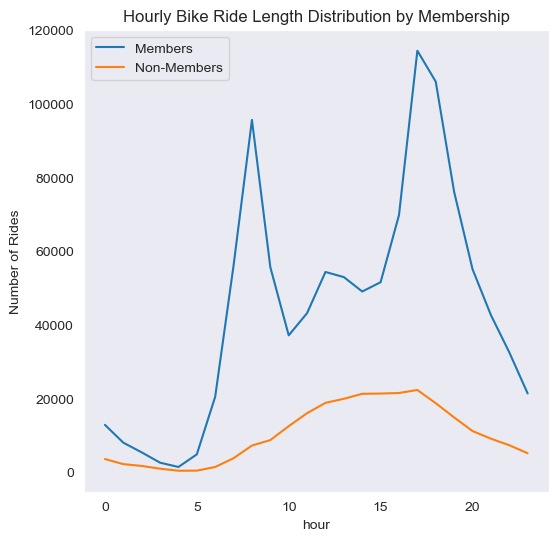

In [13]:
df[df.member_type == 1].groupby('hour')['duration'].count().plot(figsize=(6,6))
df[df.member_type == 0].groupby('hour')['duration'].count().plot()
plt.legend(['Members', 'Non-Members'])
plt.title('Hourly Bike Ride Length Distribution by Membership')
plt.ylabel('Number of Rides');

Text(0, 0.5, 'Number of Rides')

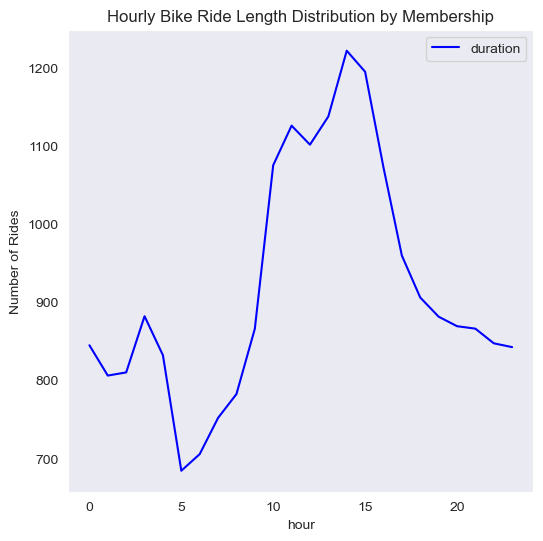

In [14]:
fig, ax = plt.subplots()
df.groupby('hour')['duration'].mean().plot(figsize=(6,6), color='b', ax=ax)
ax.legend()
plt.title('Hourly Bike Ride Length Distribution by Membership')
plt.ylabel('Number of Rides')

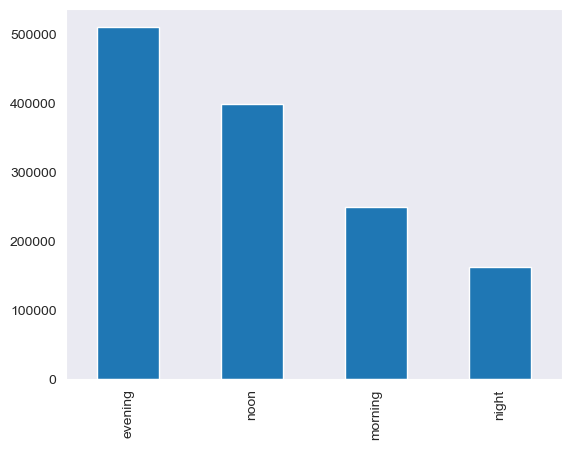

In [15]:
def format_time_day(row):
    ''' Reformats the starttime column to a categorical variable.
    '''
    if row >= 6 and row < 10:
        return 'morning'
    elif row >= 10 and row <= 15:
        return 'noon'
    elif row > 15 and row <= 20:
        return 'evening'
    return 'night'

df['time_of_day'] = df['hour'].apply(format_time_day)
df.drop('hour', axis=1, inplace=True)
df['time_of_day'].value_counts().plot.bar();

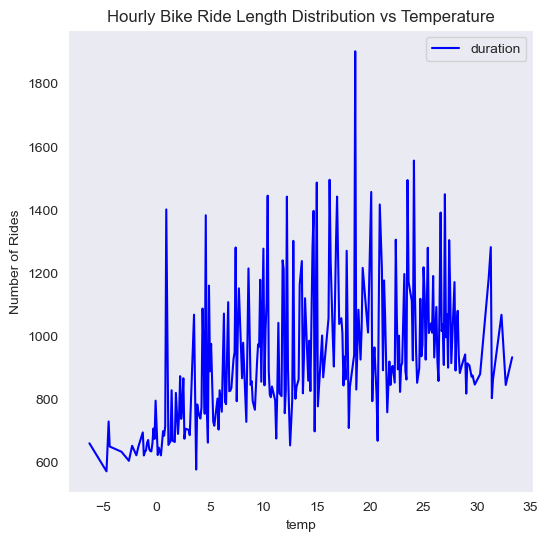

In [16]:
fig, ax = plt.subplots()
df.groupby('temp')['duration'].mean().plot(figsize=(6,6), color='b', ax=ax)
plt.title('Hourly Bike Ride Length Distribution vs Temperature')
plt.ylabel('Number of Rides')
ax.legend();

It seems that below 0 degrees there is a drop in ride duration. This may affect the results so we will add a dummy variable that distinguishes between temperatures above and below 0 degrees.

In [17]:
df['temp'] = np.where(df.temp >= 0, 'regular', 'cold')
df = pd.get_dummies(df, columns=['conditions', 'is_weekend', 'time_of_day', 'temp'], drop_first=True)
df.rename({'is_weekend_weekend': 'is_weekend',},axis=1, inplace=True )

We now turn the string variables into categorical variables that can be used with ML models. The reason we drop first is because the the last dummy variable is perfectly predicted by the other dummy variables for that category, therefore it is a redundant column and is called the "Dummy Variable Trap."

<AxesSubplot:title={'center':'Figure 1: Predictors Correlation Matrix'}>

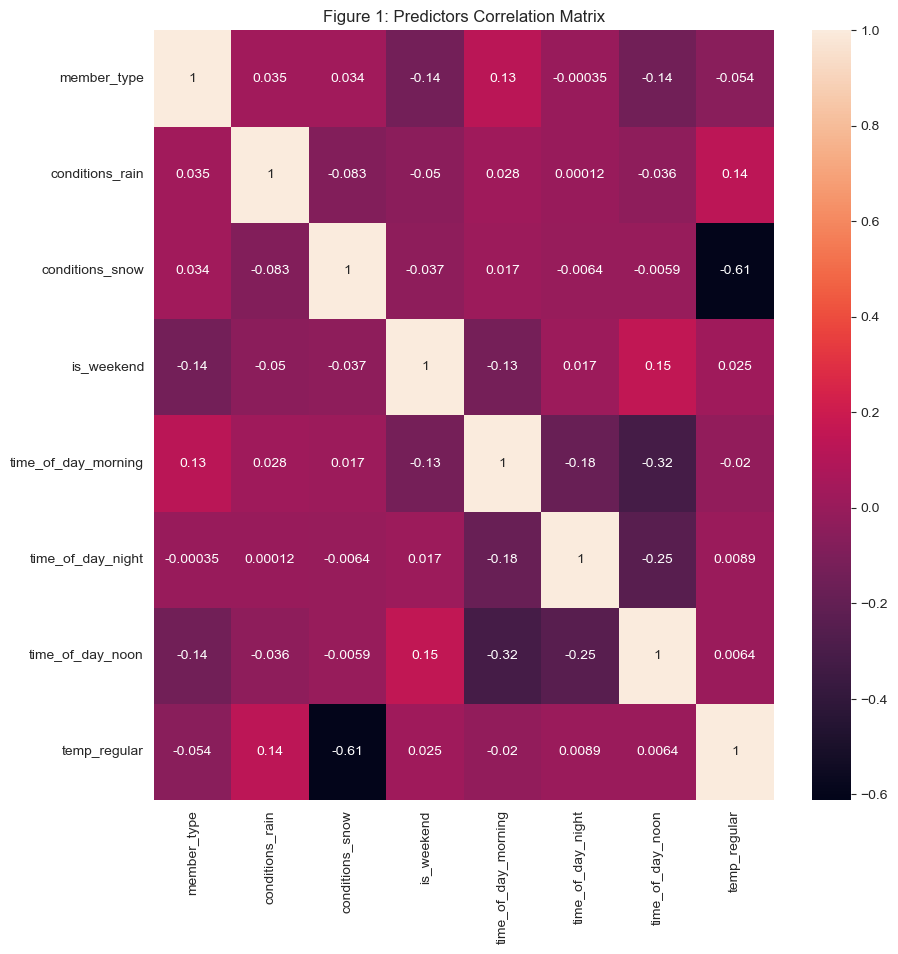

In [18]:
fig, ax = plt.subplots(figsize=(10,10)) 
confounders = df.drop(['days_since_jan1_2010', 'route', 'duration'], axis=1)
plt.title('Figure 1: Predictors Correlation Matrix')
sns.heatmap(confounders.corr(), annot=True, ax=ax)

There doesn't appear to be much correlation between the confounders which is important for protecting against multicollinearity issues. 

Now that the data is cleaned and formatted, the real analysis can begin in the next notebook.

In [19]:
df.to_csv('formatted_bike_data.csv')